# Building an Ocean model

The objective: understand the basics behind a simple particle tracking simulation using Oceananigans.jl

## What is Oceananigans.jl?

***Oceananigans.jl*** is an ocean modeling library built in the julia programming language. <br>
Oceananigans is designed to be user friendly and flexible and is capable of performing all type of <br>
simulations, from _small scale_ "isotropic" simulation to _large scale_ realistic oceans! <br>

In this lab you will learn the syntax of Oceananigans.jl and bits of ***julia*** (data structures, downloading data, plotting) <br>
mostly in the context of the Oceananigans package, as we go along. You will learn how to set <br>
up and run a simple simulation with Oceananigans.

This includes going through all the Oceananigans building blocks (if time allows it!):
1) Grids (this module)<br>
2) Fields (this module)<br>
3) Models (module 2)<br>
4) Simulation (module 2)<br>

If you are interested in learning more about julia and Oceananigans get in touch on the #julia-helpdesk slack channel



# Part 1: Install a package, download and visualize data

## Packages in julia

As Python, also julia relies on a package system. <br>

To add and load a package it is possible to use the in-built package manager. <br>
For example, if we want to install the package "Downloads" (link) we can add it through `Pkg.add("Downloads")`. <br>
Once it is installed, to use it we can write `using Downloads`

In [ ]:
using Pkg
Pkg.add("Downloads")
using Downloads

Oceananigans is already installed in the hub so it is not 
necessary to `Pkg.add("Oceananigans")`. 

We can simply start using Oceananigans with

In [1]:
# Pkg.add("Oceananigans")
using Oceananigans

### First step: define the domain

The ocean has a variable seabed height and is bounded by continents and islands. All this information is visualized through a _bathymetry_ map. <br>
The term "bathymetry" refers to the ocean's depth relative to sea level. <br>
In the same way a _topographic_ map decribes the elevation of terrain, a _bathymetric_ map illustrates the land that lies underwater. 

The bathymetry will define the domain in which we set up the ocean model. <br>

A dataset containing the bathymetric information can be found online at https://github.com/simone-silvestri/coessing-data/blob/main/bathymetry.jld2.

However, we can download this file within julia leveraging the julia infrastructure.
To download files in julia we can use the `Downloads` package (https://docs.julialang.org/en/v1/stdlib/Downloads/). <br>
This package allows to download data from an online path into your local folder and provides a path to the downloaded data.

In [ ]:
using Downloads: download

# We need to define the remote path to the file
onlinepath = "https://github.com/simone-silvestri/coessing-data/raw/main/"

file_path = download(onlinepath * "bathymetry.jld2", "./bathymetry.jld2")

### JLD2 filetype

The file has been downloaded and is available at the path `"./bathymetry.jld2"`. <br>
Note that the file has the `*.jld2` extension. <br>
This a julia filetype (same as `*.hdf5` in python) which can be opened using the `JLD2` package

In [2]:
using JLD2
file_bathymetry = jldopen(file_path)

JLDFile /Users/simonesilvestri/development/coessing2022-hub/julia-ocean-model/bathymetry.jld2 (read-only)
 └─🔢 bathymetry

A _JLDFile_ is a `Dictionary`, a collection of datasets that can be accessed using _strings_ as keys <br>
(akin to how Dictionaries work in python). <br>
The bathymetry can be accessed with the key "bathymetry"

In [3]:
bathymetry = file_bathymetry["bathymetry"]

# Let's look at the type and size of the variable _bathymetry_
@show size(bathymetry)
@show typeof(bathymetry)

size(bathymetry) = (1440, 600)
typeof(bathymetry) = Matrix{Float64}


Matrix{Float64} (alias for Array{Float64, 2})

The bathymetric map we loaded is a `Matrix` (which is the same as a two-dimensional array `Array`) <br>
of size 1440x600. You can think of these numbers as the _resolution_ (number of pixel) of the map. <br>

### Plotting 2D data

Let's plot the bathymetry and visualize underwater elevation <br>
Plotting in julia can be done through the package `CairoMakie` <br>

CairoMakie is quite user friendly to use, the step to plotting are:
- define a figure as `fig = Figure()`. A resolution can be specified. The position in the figure can be indexed as a matrix
- specify an axis in the figure `ax = Axis(fig[1, 1])` (1, 1 stands for position 1, 1 in the figure layout)
- plot something inside the axis (using `ax` as an argument)

Since we will work with simulations of the ocean surface (two dimensional), <br>
we can use the `heatmap!` function which plots matrices (`contour!` could have been another choice). <br>
In a heatmap the `colorrange` keyword specifies the limits of the contour. <br>
The colormap is specified with the `colormap` keyword (choice of different colormaps, :balance, :hot, :viridis, :plasma, etc...)


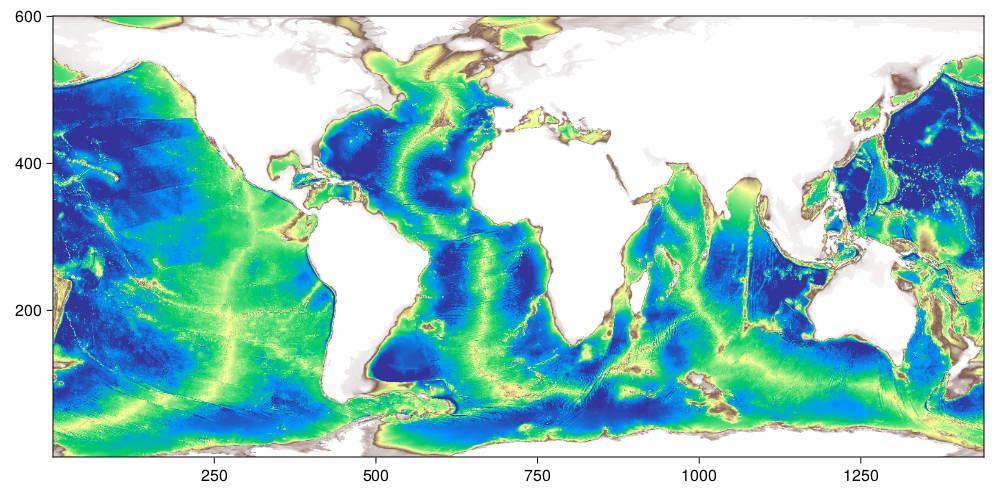

In [19]:
using CairoMakie

fig = Figure(resolution = (1000, 500))
ax  = Axis(fig[1, 1])

heatmap!(ax, bathymetry, colorrange = (-5500, 100), colormap = :terrain)

current_figure()

# Part 2: build a computational Grid

The fluid in the ocean is _continuous_, but a computer can only operate on _discrete_ quantities (vectors, arrays, matrices). <br>
To _represent_ a continuous fluid on a computer we need to _discretize_ our geometry into "computational cells".
All computational cells together form a ***grid*** (or a ***mesh***).

Grids are the backbone of ***all*** fluid flow simulations: constructing an adequate grid goes a long way in ensuring a good quality model.

Oceananigans allows to construct two types of grids: 
- a `RectilinearGrid` for problems defined in a rectangular space
- a `LatitudeLongitudeGrid` for problems defined on a sphere

If we want to discretize the ocean, we need a sphere! <br>

Let's choose the number of points in the latitude and longitude direction (`Nlat` and `Nlon`) and construct our grid <br>
We are going to simulate the transport over the ocean surface so we don't need a "vertical" direction. <br>
The size of the grid will, hence, be `(Nlat, Nlon, 1)`


In [29]:
Nlon = 1440
Nlat = 600

initial_grid = LatitudeLongitudeGrid(size = (Nlon, Nlat, 1), longitude = (-180, 180), latitude = (-75, 75), z = (0, 1))

1440×600×1 LatitudeLongitudeGrid{Float64, Periodic, Bounded, Bounded} on CPU with 3×3×3 halo and with precomputed metrics
├── longitude: Periodic λ ∈ [-180.0, 180.0) regularly spaced with Δλ=0.25
├── latitude:  Bounded  φ ∈ [-75.0, 75.0]   regularly spaced with Δφ=0.25
└── z:         Bounded  z ∈ [0.0, 1.0]      regularly spaced with Δz=1.0

Take a second to look at the informations contained in this grid <br>
(spacing and limits for each direction which can be periodic or bounded) <br>

At the moment this grid is just a spherical shell. <br>
To convert it into a realistic representation of the ocean we have to load in the bathymetric map <br>

some convenience functions to interpolate our domain (the bathymetric map) onto the grid <br> are implemented in the file "useful_functions.jl" (within the folder "utils")

In julia we can load source files `(*.jl)` through the function `include`. <br>
This will load all the functions defined in the source file. <br>
(you are welcome to look at the functions defined in "utils/useful_functions.jl")

In [30]:
include("utils/useful_functions.jl")
grid = immersed_boundary_grid(initial_grid, bathymetry);

You can use the `visualize_cartesian_grid` function (defined in "useful_functions.jl") to plot the grid. <br> 
It uses the `CairoMakie` package to visualize a wireframe of the computational cells and a 
heatmap of the discrete continental mask.

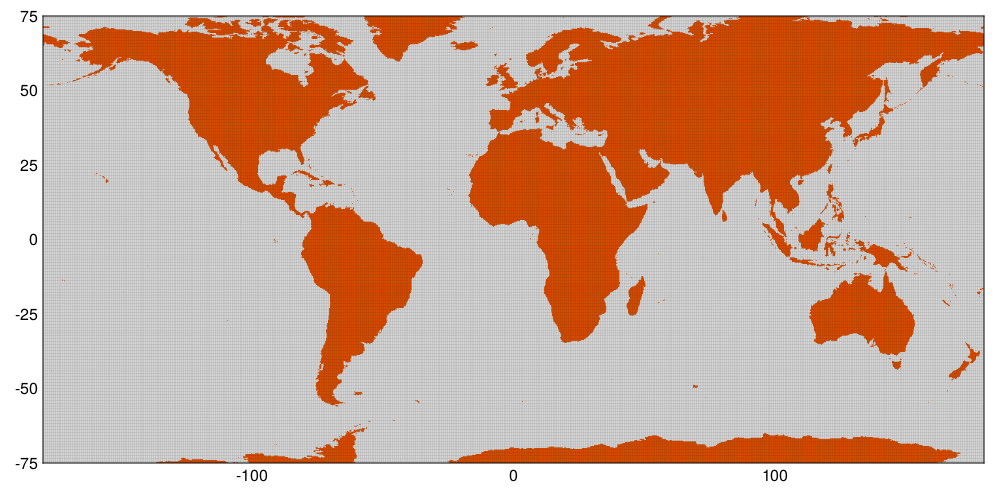

In [31]:
fig = visualize_cartesian_grid(grid)
current_figure()

You can think at the number of cells in a grid as the number of pixel in an image; more pixels in an image allow you to see more details. <br>
The same happens in an ocean simulation, the more cells (pixel) in your grid, <br>
the more detailed physics you can resolve.

## Exercise: change the grid resolution

try changing the number of points in the longitudinal (`Nlat`) and the latitudinal (`Nlon`) direction, <br>
and see for yourself how the representation of the continents change.

What do you think will happen?

you can also chenage the latitude and longitude of the domain to "zoom in" in particular regions <br>
For example you can try `latitude = (-35, 30)` and `latitude = (-30, 30)` to zoom into west africa's coast

#### Note!
the bathymetry data has a size of (1440 x 600) so the maximum resolution allowable is `Nx = 1440`, `Ny = 600`

In [ ]:
## Write the new grid here
## look at the examples above:

# - define Nlon and Nlat
# - build an initial_grid (choose latitude = (ᵒwest, ᵒeast), longitude = (ᵒsouth, ᵒnorth))
# - build the grid with the immersed_boundary_grid function
# - visualize with the visualize_figure function
# - display the figure with current_figure()

# Part 3: download and interact with a velocity field

### Download velocity datasets

To download the (precomputed) velocity datasets we, once again, use the `Downloads` package.

The file containing the velocity datasets can be found online at https://github.com/simone-silvestri/coessing-data/raw/main/prescribed_mean_fields.jld2

In [9]:
onlinepath = "https://github.com/simone-silvestri/coessing-data/raw/main/"

file_path = download(onlinepath * "prescribed_mean_fields.jld2", "./prescribed_mean_fields.jld2")

file_velocities = jldopen(file_path)

JLDFile /Users/simonesilvestri/development/coessing2022-hub/julia-ocean-model/prescribed_surface_fields.jld2 (read-only)
 ├─🔢 u
 ├─🔢 v
 ├─🔢 um
 └─🔢 vm

This file is a Dictionary containing two datasets:
- um
- vm 

Here `um` is the _zonal_ surface velocity (the surface velocity in the West-East direction) <br>
and `vm` is the _meridional_ surface velocity (the surface velocity in the South-North direction, along meridians). <br>
 
these datasets contain the ***average*** velocities over a time span of 10 years. <br>
Let's assign these datasets to two variables and look at their structure

In [10]:
const Um = file_velocities["um"]
const Vm = file_velocities["vm"]

@show typeof(Um);
@show size(Um);
@show typeof(Vm)
@show size(Vm);

typeof(Um) = Array{Float64, 3}
size(Um) = (1440, 600, 1)
typeof(Vm) = Array{Float64, 3}
size(Vm) = (1440, 601, 1)


Note that both the Arrays (`Um` and `Vm`) are ***3D*** arrays! Oceananigans always works with three dimensional data for simplicity, <br>
a two dimensional dataset (as in this case) is represented by a 3D array with ***one*** point in the unused direction

let's plot the zonal velocity with `CairoMakie`. <br>
Since `Um` is a 3D array, we can plot it as `Um[:, :, 1]` (heatmap plots only 2D arrays)

In [ ]:
# Mean zonal velocity
u = Um[:, :, 1]

fig = Figure(resolution = (1000, 500))
ax  = Axis(fig[1, 1])
heatmap!(ax, u, colorrange = (-0.2, 0.2), colormap = :viridis)
current_figure()

Let's plot the meridional velocity (along latitude lines) in the same way

In [ ]:
# Mean meridional velocity
v = Vm[:, :, 1]

fig = Figure(resolution = (1000, 500))
ax  = Axis(fig[1, 1])
heatmap!(ax, v, colorrange = (-0.1, 0.1), colormap = :viridis)
current_figure()

### Oceananigans' `Field` type

Oceananigans represents variables discretized onto a particular grid with a `Field` type. <br> 
Fields are essentially containers which include the grid, the data allocated on the grid (the previously seen 3D arrays), <br>
and the associated boundary conditions.

We can define empty fields (i.e., empty containers associated with a grid) for our velocities and fill them with the velocity data we loaded

In [11]:
# Fields have a `location` in x, y and z. 
# They can be either poisitioned at the `Face` of the computational cell
# or at the `Center` of the cell

# By convention, U velocity is positioned at x `Face`s and `V` at y `Face`s
u_location = (Face, Center, Center)
v_location = (Center, Face, Center)

U = Field(u_location, grid)
V = Field(v_location, grid)

set_velocity_from_array!(U, Um)
set_velocity_from_array!(V, Vm)

1440×601×1 Field{Center, Face, Center} on ImmersedBoundaryGrid on CPU
├── grid: 1440×600×1 ImmersedBoundaryGrid{Float64, Periodic, Bounded, Bounded} on CPU with 3×3×3 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: Periodic, east: Periodic, south: Nothing, north: Nothing, bottom: ZeroFlux, top: ZeroFlux, immersed: ZeroFlux
└── data: 1446×607×7 OffsetArray(::Array{Float64, 3}, -2:1443, -2:604, -2:4) with eltype Float64 with indices -2:1443×-2:604×-2:4
    └── max=2.11723, min=-1.68651, mean=0.00532211

### Combining fields

Fields are handy because they can be combined through expressions. <br>
as an example, let's calculate the mean kinetic energy at the surface defined as

$$K = 0.5 * (U^2 + V^2)$$

In [ ]:
K = Field(0.5 * (U^2 + V^2))
compute!(K)

Now let's see how kinetic energy of the surface looks like. <br>
We can plot it with `CairoMakie` (as we have done before), but only after extracting the data! <br>

To access the data associated with an Oceananigans field we can use the function `interior`

In [ ]:
k = interior(K)

# The data associated with a field is always three dimensional!
@show typeof(k);

fig = Figure(resolution = (1000, 500))
ax = Axis(fig[1, 1])
heatmap!(ax, k[:, :, 1], colorrange = (0, 0.05), colormap = :solar)

current_figure()

### Computing derivatives

In the same way we can compute derivatives. <br>
For example, let's calculate and plot the latitudinal derivative of the zonal velocity
$$S = \frac{\partial U}{\partial x}$$

Note that julia supports Unicode. <br>
The differentiation operator in Oceananigans is defined with the $\partial$ symbol. <br>
To write it out in julia, type `\partial` and then press the TAB key

In [ ]:
S = Field(∂x(U))
compute!(S)

s = interior(S)

fig = Figure(resolution = (1000, 500))
ax  = Axis(fig[1, 1])
heatmap!(ax, s[:, :, 1], colorrange = (-2e-6, 2e-6), colormap = :balance)

current_figure()

## Exercise: interact with the velocity field

define and plot a new field as a function of `U` and `V`

As an example you could calculate vertical vorticity ($\zeta$) or the horizontal divergence ($\delta$), where: 

$$\zeta = \frac{\partial V}{\partial x} - \frac{\partial U}{\partial y} \ , \ \ \ \ \text{and} \ \ \ \ \delta = \frac{\partial U}{\partial x} + \frac{\partial V}{\partial y}$$

#### Remember!
- the derivative operator in Oceananigans is constructed with \partial+TAB (followed by the direction: x or y)
- heatmap plots 2D AbstractArrays (SubArrays are AbstractArrays)
- the data of a field is retrieved by the `interior` function
- Fields (and associated data) are _always_ three dimensional

#### Tips
- You can use the `typeof` and `size` function to confirm that the variable you want to plot is a 2D array (or matrix)
- Follow the example above for plotting and use `colorrange = (extrema(field))` and `colormap = :blues`
- don't forget to display the figure with `current_figure()` at the end of the cell!

In [15]:
## Write the new field here
## look at the examples above:

# - define the operation you want to calculate (ex: U + 0.5 * V)
# - wrap it around a Field constructor (field = Field(expression))
# - compute the field with compute!(field)
# - extract the data with data = interior(field)
# - display the data with heatmap!